# imports

In [1]:
import pandas as pd
import re
import os
import seaborn as sns
import locale
locale.setlocale(locale.LC_ALL, 'es_MX')
%matplotlib inline
dir_dof = 'D:/datos/dof'
# https://funcionpublica.gob.mx/scagp/dgorcs/reglas/2006/r04_gobernacion06/SEGOB%2006%20FONDEN%20ROP%20Lin.%20DE%20y%20FR%20200906.doc

# Crea DF de emergencias
Nota: La siguiente celda crea el dataframe que contiene solo las notas de Declaratorias de Emergencias.
No es necesario ejecutarla para reproducir las gráficas de más abajo.
Los datos usados se pueden descargar en el sitio de datos del [LNPP](http://datos.cide.edu/handle/10089/17462)

In [150]:
pat_estados = '(Aguascalientes|Baja California Sur|Baja California(?!\s?sur)|Campeche|Coahuila de Zaragoza|Coahuila|Colima|Chiapas|Chihuahua|Ciudad de México|Distrito Federal|Durango|Guanajuato|Guerrero|Hidalgo|Jalisco|Estado de México|Michoacán de ocampo|Michoacán|Morelos|Nayarit|Nuevo León|Oaxaca|Puebla|Querétaro|Quintana Roo|San Luis Potosí|Sinaloa|Sonora|Tabasco|Tamaulipas|Tlaxcala|Veracruz de Ignacio de la Llave|Veracruz|Yucatán|Zacatecas)'
pat_fenomenos = '(ciclón|depresión tropical|tormenta|huracán|lluvia|helada|nevada|granizada|inundaci\w+|tornado|frentes? fríos?|marea roja|volcán|incendio|bajas temperaturas|temperaturas mínimas|temperaturas bajas|sismo|movimientos? de ladera|precipitaci\w+|vientos|ondas? cálidas?|hundimiento|deslave)'
repl_fenomeno = {'inundaciones': 'inundación', 'precipitaciones': 'lluvia', 'Depresión Tropical': 'depresión tropical',
 'frentes fríos': 'frente frío', 'movimientos de ladera': 'movimiento de ladera', 'ondas cálidas': 'onda cálida',
 'Frente Frío': 'frente frío', 'Marea Roja': 'marea roja', 'Tormenta': 'tormenta', 'Ciclón': 'ciclón', 'temperaturas bajas': 'bajas temperaturas'}

df = pd.concat([pd.read_csv(f'{dir_dof}/dof_1917_2012.csv', usecols=['fecha', 'titulo'])]+
    [pd.read_csv(f'{dir_dof}/dof_{y}.csv', usecols=['fecha', 'titulo']) for y in range(2013, 2019)])

emergencia = df.loc[df['titulo'].str.contains(r'^declara\w+ de emergencia', case=False)]\
    .assign(fecha=lambda x: x['fecha'].pipe(pd.to_datetime))\
    .set_index('fecha')\
    .assign(estado=lambda x: x['titulo'].str.extract(pat_estados, flags=re.IGNORECASE)[0],
           fenomeno=lambda x: x['titulo'].str.extract(pat_fenomenos, flags=re.IGNORECASE)[0].replace(repl_fenomeno),
           mes=lambda x: x.index.month,
           mes_es=lambda x: x.index.strftime('%B'))

emergencia.to_csv('datos/emergencias.csv')

# Graficas

## Datos

In [2]:
emergencias = pd.read_csv('datos/emergencias.csv', parse_dates=['fecha'], index_col='fecha')
emergencias.head()

,titulo,estado,fenomeno,mes,mes_es
fecha,,,,,
2000-06-02,Declaratoria de Emergencia para efectos de las...,NaN,lluvia,6,junio
2000-08-16,Declaratoria de Emergencia para efectos de las...,Tamaulipas,tormenta,8,agosto
2000-09-19,Declaratoria de Emergencia para efectos de las...,Baja California Sur,tormenta,9,septiembre
2000-09-22,Declaratoria de Emergencia para efectos de las...,Colima,depresión tropical,9,septiembre
2000-09-22,Declaratoria de Emergencia para efectos de las...,Guerrero,depresión tropical,9,septiembre


In [4]:
emergencias.shape

(1102, 5)

## Total por año

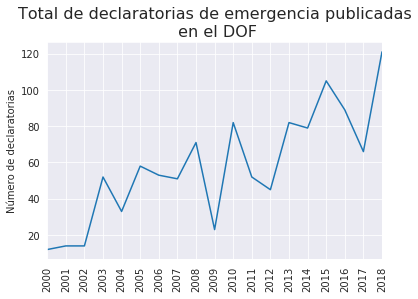

In [14]:
with sns.axes_style('darkgrid'):
    years = emergencias.index.year.unique().tolist()
    ny = len(years)
    ax = emergencias.resample('Y').agg('size').plot()
    ax.set_xlabel('')
    ax.set_ylabel('Número de declaratorias')
    ax.set_title('Total de declaratorias de emergencia publicadas\n en el DOF', fontsize=16)
    ax.set_xticks(range(30, 30+ny))
    ax.set_xticklabels(years, rotation=90)
    ax.figure.savefig('graficas/emergencias_anual.png', dpi=800, bbox_inches='tight')

## Total por mes

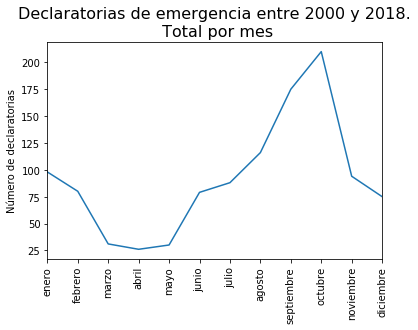

In [15]:
ax = emergencias.groupby(['mes', 'mes_es'])['titulo'].count().reset_index('mes', drop=True).plot()
meses = emergencias.sort_values('mes').index.strftime('%B').unique().tolist()
ax.set_title('Declaratorias de emergencia entre 2000 y 2018.\n Total por mes', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Número de declaratorias')
ax.set_xticks(range(len(meses)))
ax.set_xticklabels(meses, rotation=90)
ax.figure.savefig('graficas/emergencias_por_mes.png', dpi=800, bbox_inches='tight')

## Total por estado

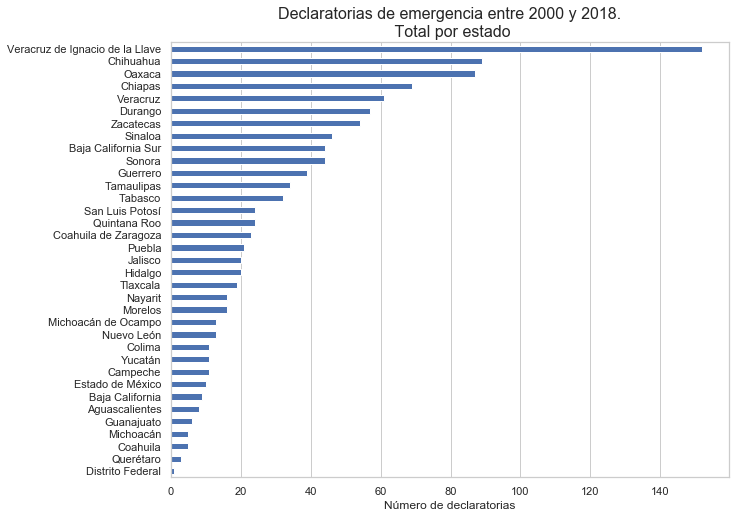

In [146]:
with sns.axes_style('whitegrid'):
    ax = emergencias.groupby('estado')['titulo'].count().sort_values().plot(kind='barh')
    ax.figure.set_size_inches(10, 8)
    ax.yaxis.grid(None)
    ax.set_ylabel('')
    ax.set_xlabel('Número de declaratorias')
    ax.set_title('Declaratorias de emergencia entre 2000 y 2018.\n Total por estado', fontsize=16)
    ax.figure.savefig('graficas/emergencias_por_estado.png', dpi=800, bbox_inches='tight')

## Por fenómeno

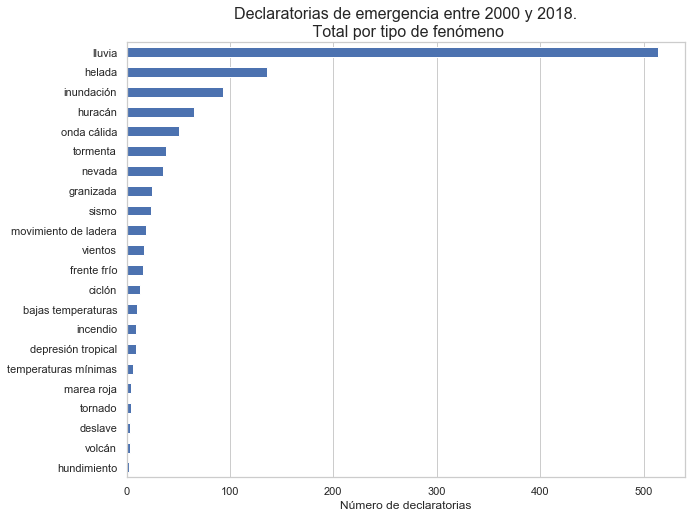

In [155]:
with sns.axes_style('whitegrid'):
    ax = emergencias.groupby('fenomeno')['fenomeno'].count().sort_values().plot(kind='barh')
    ax.figure.set_size_inches(10, 8)
    ax.yaxis.grid(None)
    ax.set_ylabel('')
    ax.set_xlabel('Número de declaratorias')
    ax.set_title('Declaratorias de emergencia entre 2000 y 2018.\n Total por tipo de fenómeno', fontsize=16)
    ax.figure.savefig('graficas/emergencias_por_fenomeno.png', dpi=800, bbox_inches='tight')